In [6]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import sys
sys.path.insert(0, '/home/sprakashdash/Documents/DLFA/')

In [8]:
# Hyperparameters
batch_size = 64
input_size = 784
hidden_size_1 = 512 # 4096
hidden_size_2 = 256 # 2048
hidden_size_3 = 128 # 1024
num_classes = 10

# Learning rate
lr = 0.0001
# Number of training epochs
num_epochs = 20
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Path to dataset
dataset_root_path = '/home/sprakashdash/Documents/DLFA/'

In [11]:
trainset = torchvision.datasets.FashionMNIST(root=dataset_root_path, train=True,\
                                             download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root=dataset_root_path, train=False,\
                                            download=True, transform=transforms.ToTensor())


0it [00:00, ?it/s]


 99%|█████████▊| 26025984/26421880 [00:06<00:00, 3486031.22it/s]
26427392it [00:06, 3794659.76it/s]                              

Extracting /home/sprakashdash/Documents/DLFA/FashionMNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]


  0%|          | 0/29515 [00:00<?, ?it/s]
32768it [00:00, 48800.85it/s]            
0it [00:00, ?it/s]

Extracting /home/sprakashdash/Documents/DLFA/FashionMNIST/raw/train-labels-idx1-ubyte.gz



 82%|████████▏ | 3604480/4422102 [00:03<00:00, 1419983.97it/s]

0it [00:00, ?it/s]

Extracting /home/sprakashdash/Documents/DLFA/FashionMNIST/raw/t10k-images-idx3-ubyte.gz




  0%|          | 0/5148 [00:00<?, ?it/s]

8192it [00:00, 15954.16it/s]            

Extracting /home/sprakashdash/Documents/DLFA/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [12]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [13]:
print(trainloader.dataset.train_data.shape)
print(trainloader.dataset.train_labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


/home/sprakashdash/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/sprakashdash/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")

4423680it [00:21, 1419983.97it/s]                             

### The classes are defined in the main repo in [Github](https://github.com/zalandoresearch/fashion-mnist#Labels)

In [14]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle-boot')

#### Let us show some of the training images, for fun

torch.Size([64, 1, 28, 28])
torch.Size([64])


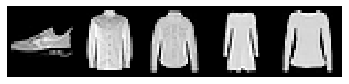

Sneaker Shirt Shirt Dress Pullover


In [15]:
# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    
# Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

# Show images
imshow(torchvision.utils.make_grid(images[:5],nrow=5))
# Print their labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [16]:
# Fully connected neural network with three hidden layer
class NeuralNetThreeLayer(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, num_classes):
        super(NeuralNetThreeLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_3, num_classes)
        
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

net = NeuralNetThreeLayer(input_size, hidden_size_1, hidden_size_2, hidden_size_3, num_classes)
net = net.to(device)

Define a Loss function and optimizer

---



In [17]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=lr)

In [18]:
# Helper function to test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
def eval(testloader, epoch):
    # print('here')
    with torch.no_grad():
        running_loss_test = 0.0
        test_correct = 0
        test_total = 0
        test_i = 0
        for test_images, test_labels in testloader:
            # get the inputs
            test_images = test_images.reshape(-1, 28*28).to(device)
            test_labels = test_labels.to(device)
            test_outputs = net(test_images)
            test_loss = criterion(test_outputs, test_labels)
            _, test_predicted = torch.max(test_outputs.data, 1)
            
            running_loss_test += test_loss.item()
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()
            test_i += 1

            if test_total >= testloader.dataset.test_data.shape[0]-batch_size:
                print('[{:d}], test accuracy: {:4.2f} %, test_loss {:.5f}'.format(epoch+1, \
                                                100*test_correct/test_total, running_loss_test/(test_i+1)))
                break
        return 100*test_correct/test_total, running_loss_test/(test_i+1)

In [19]:
# Eval on training data. This is to be run with initial model only
# In eval phase, we don't need to compute gradients (for memory efficiency)
def eval_initial_model(trainloader):
    with torch.no_grad():
        running_loss_train = 0.0
        train_correct = 0
        train_total = 0
        train_i = 0
        for train_images, train_labels in trainloader:
            # get the inputs
            train_images = train_images.reshape(-1, 28*28).to(device)
            train_labels = train_labels.to(device)
            train_outputs = net(train_images)
            train_loss = criterion(train_outputs, train_labels)
            _, train_predicted = torch.max(train_outputs.data, 1)
            
            running_loss_train += train_loss.item()
            train_total += train_labels.size(0)
            train_correct += (train_predicted == train_labels).sum().item()
            train_i += 1
        
        print('[0], train accuracy: {:4.2f} %, train_loss {:.5f}'.format(100*train_correct/train_total, \
                                                                        running_loss_train/(train_i+1)))
        return 100*train_correct/train_total, running_loss_train/(train_i+1)

In [20]:
test_acc = [0.0]*(num_epochs+1)
test_loss = [0.0]*(num_epochs+1)
train_acc = [0.0]*(num_epochs+1)
train_loss = [0.0]*(num_epochs+1)
lst_counter = 0

train_acc[lst_counter], train_loss[lst_counter] = eval_initial_model(trainloader)
test_acc[lst_counter], test_loss[lst_counter] = eval(testloader, 0)
lst_counter += 1

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss_training = 0.0
    correct = 0
    total = 0
    i = 0
    # for i, data in enumerate(trainloader, 0):
    for inputs, labels in trainloader:
        # get the inputs
        # inputs, labels = data
        inputs = inputs.reshape(-1, 28*28).to(device); labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        training_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        
        training_loss.backward()
        optimizer.step()

        # print statistics
        running_loss_training += training_loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        i += 1
        if total >= trainloader.dataset.train_data.shape[0]: # or (epoch == 0 and i == 0):
            print('[{:d}] train accuracy: {:4.2f} % train loss: {:.5f}'.format(epoch+1, \
                                                            100*correct/total, running_loss_training/(i+1)))
            train_acc[lst_counter] = 100*correct/total
            train_loss[lst_counter] = running_loss_training/(i+1)
            
            running_loss_training = 0.0
            
            test_acc[lst_counter], test_loss[lst_counter] = eval(testloader, epoch)
            lst_counter += 1

print('Finished Training')

[0], train accuracy: 11.30 %, train_loss 2.30089


/home/sprakashdash/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


[1], test accuracy: 11.26 %, test_loss 2.28860
[1] train accuracy: 73.79 % train loss: 0.75173
[1], test accuracy: 79.84 %, test_loss 0.55185
[2] train accuracy: 83.71 % train loss: 0.46546
[2], test accuracy: 83.66 %, test_loss 0.46679
[3] train accuracy: 85.31 % train loss: 0.42034
[3], test accuracy: 84.31 %, test_loss 0.43979
[4] train accuracy: 86.20 % train loss: 0.39004
[4], test accuracy: 85.40 %, test_loss 0.40890
[5] train accuracy: 86.91 % train loss: 0.37047
[5], test accuracy: 86.13 %, test_loss 0.38870
[6] train accuracy: 87.41 % train loss: 0.35183
[6], test accuracy: 86.35 %, test_loss 0.37662
[7] train accuracy: 87.88 % train loss: 0.33632
[7], test accuracy: 86.64 %, test_loss 0.36974
[8] train accuracy: 88.43 % train loss: 0.32196
[8], test accuracy: 86.66 %, test_loss 0.37621
[9] train accuracy: 88.89 % train loss: 0.30853
[9], test accuracy: 87.46 %, test_loss 0.34828
[10] train accuracy: 89.14 % train loss: 0.29946
[10], test accuracy: 87.76 %, test_loss 0.34300
[

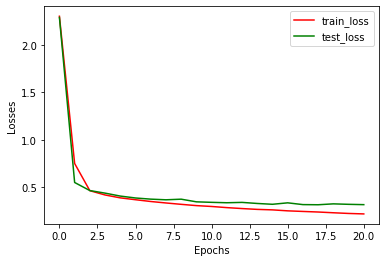

In [21]:
# Plotting train and test loss vs Epochs
fig1 = plt.figure(1)        
plt.plot(range(num_epochs+1),train_loss,'r-',label='train_loss')        
plt.plot(range(num_epochs+1),test_loss,'g-',label='test_loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.show()

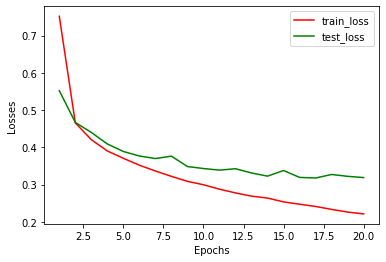

In [22]:
fig2 = plt.figure(1)        
plt.plot(range(1, num_epochs+1),train_loss[1:],'r-',label='train_loss')        
plt.plot(range(1, num_epochs+1),test_loss[1:],'g-',label='test_loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.show()

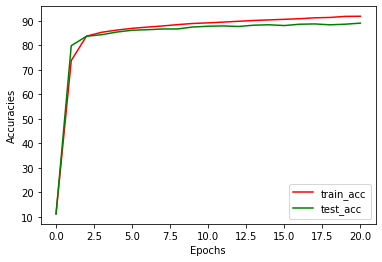

In [23]:
# Plotting train and test accuracy vs Epochs
fig3 = plt.figure(1)        
plt.plot(range(num_epochs+1),train_acc,'r-',label='train_acc')        
plt.plot(range(num_epochs+1),test_acc,'g-',label='test_acc')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.show()

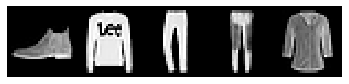

GroundTruth:  Ankle-boot Pullover Trouser Trouser Shirt
Predicted:  Ankle-boot (0.98) Pullover (1.00) Trouser (1.00) Trouser (1.00) Shirt (0.76)


In [26]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:5], nrow=5))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))

# Get the predicted outputs
images = images.reshape(-1, 28*28).to(device)
labels = labels.to(device)
outputs = net(images)
outputs_softmax = F.softmax(outputs, dim=1)
probabilities, predicted = torch.max(outputs_softmax, 1)
probabilities_np = probabilities.cpu().data.numpy()
print('Predicted: ', ' '.join('%5s (%.2f)' % (classes[predicted[j]], probabilities[j]) for j in range(5)))